In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
train_df = pd.read_parquet('data/train_dataset_hackaton2023_train.gzip')
test_df = pd.read_parquet('data/hackaton2023_test.gzip')

## Проверка типов

In [12]:
print(train_df.dtypes)
print('----')
print(test_df.dtypes)

customer_id                int64
date_diff_post           float64
buy_post                   int64
group_name                object
revenue                  float64
startdatetime     datetime64[us]
dish_name                 object
ownareaall_sqm           float64
format_name               object
dtype: object
----
customer_id                int64
group_name                object
revenue                  float64
startdatetime     datetime64[us]
dish_name                 object
ownareaall_sqm           float64
format_name               object
dtype: object


## Пропуски

In [14]:
print(train_df.isnull().sum())
print('---')
print(test_df.isnull().sum())

customer_id             0
date_diff_post    2468517
buy_post                0
group_name              0
revenue                 0
startdatetime           0
dish_name               0
ownareaall_sqm          0
format_name             0
dtype: int64
---
customer_id       0
group_name        0
revenue           0
startdatetime     0
dish_name         0
ownareaall_sqm    0
format_name       0
dtype: int64


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12129384 entries, 0 to 24261978
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   customer_id     int64         
 1   date_diff_post  float64       
 2   buy_post        int64         
 3   group_name      object        
 4   revenue         float64       
 5   startdatetime   datetime64[us]
 6   dish_name       object        
 7   ownareaall_sqm  float64       
 8   format_name     object        
dtypes: datetime64[us](1), float64(3), int64(2), object(3)
memory usage: 925.4+ MB


## Самое популярное блюдо по месяцам с учетом категории клиента

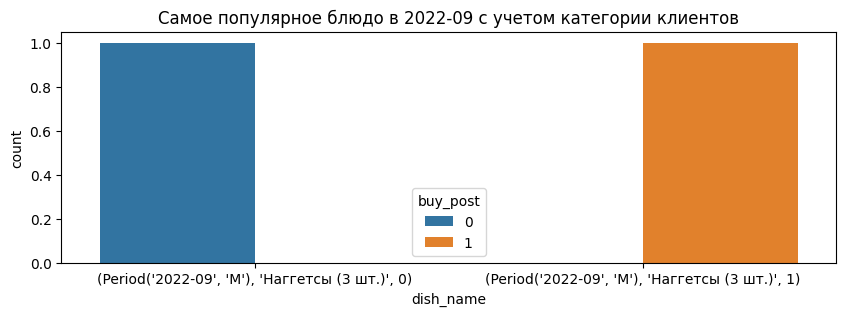

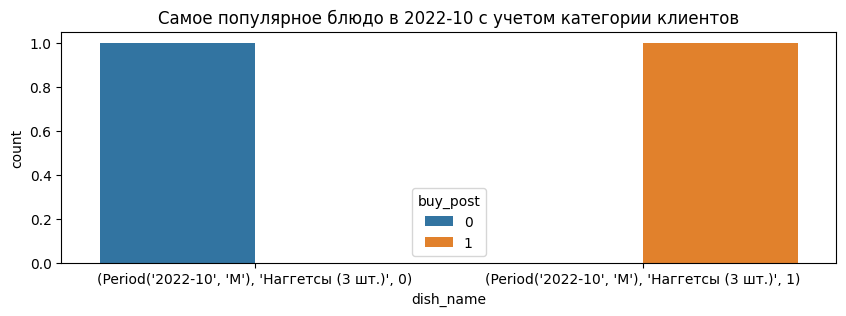

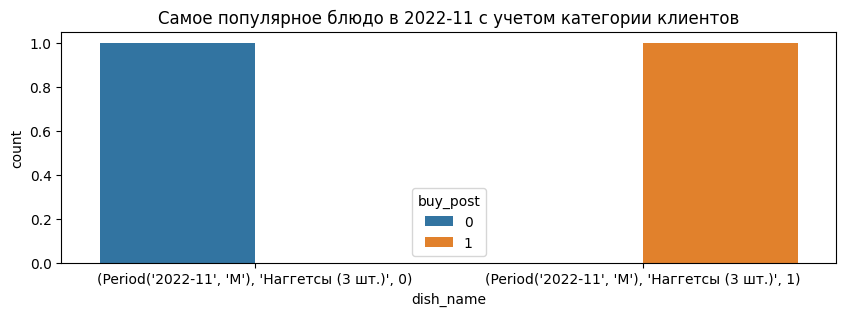

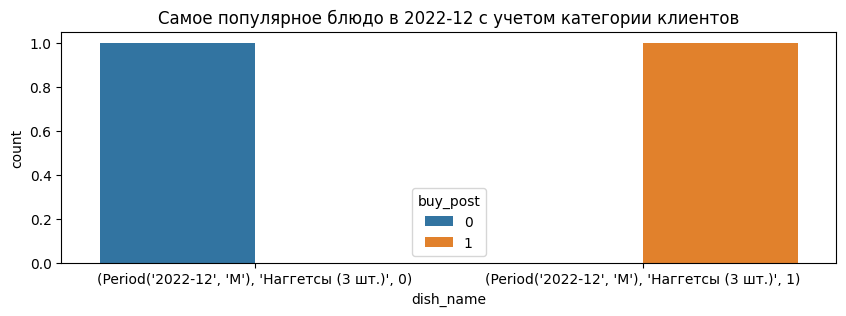

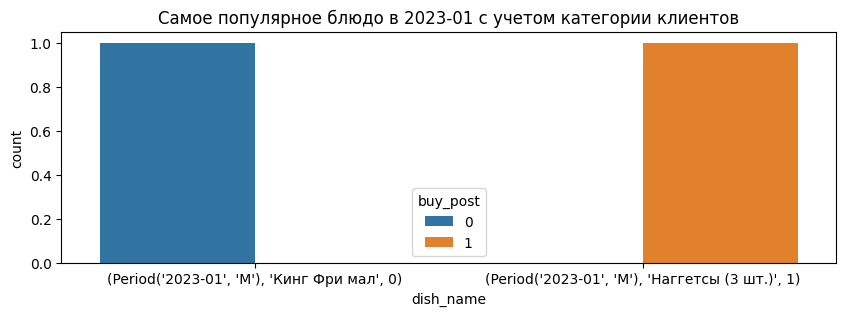

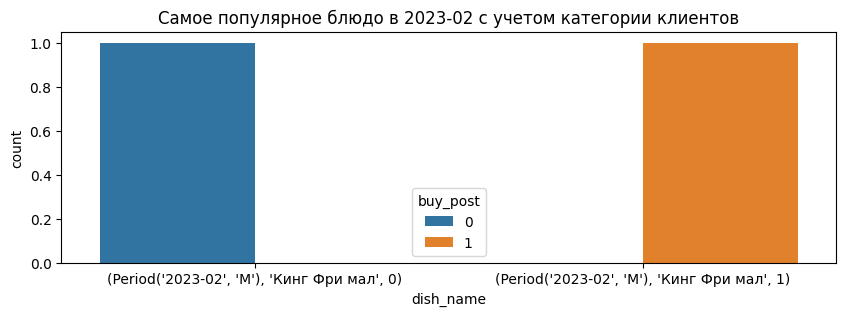

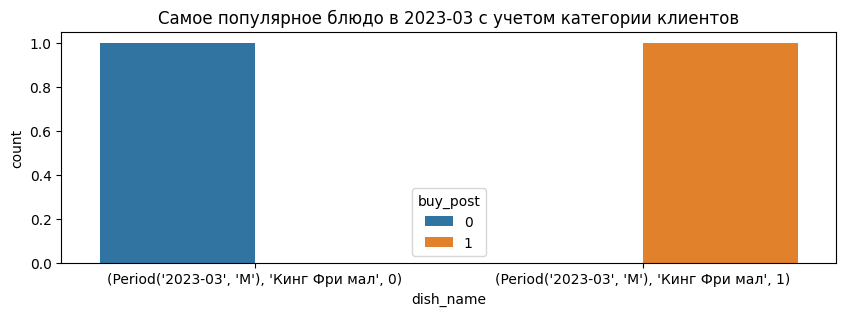

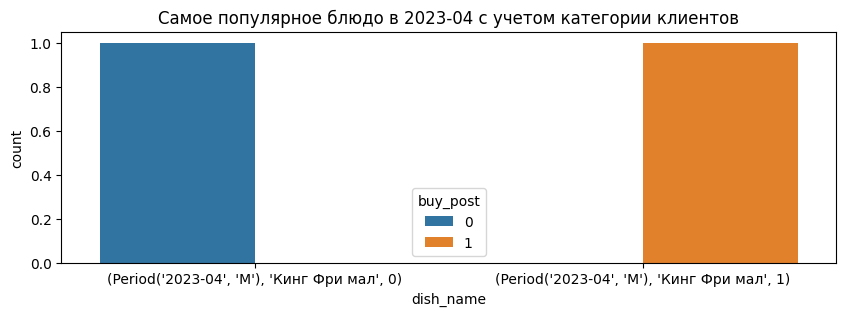

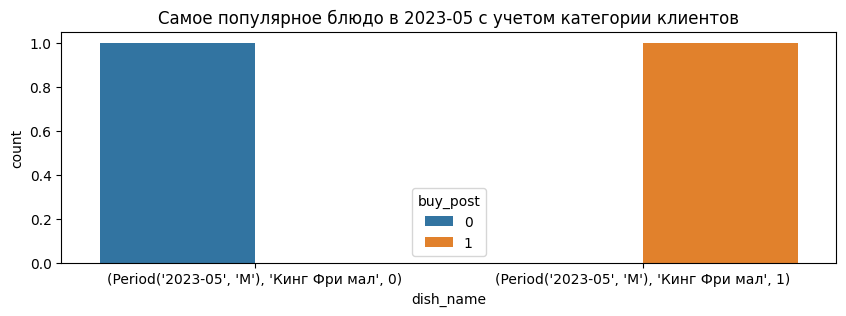

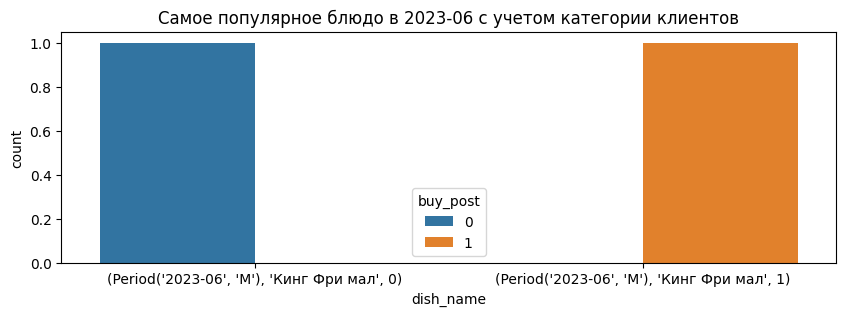

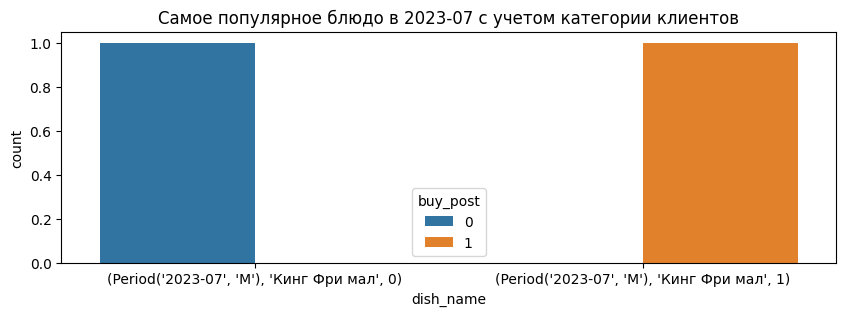

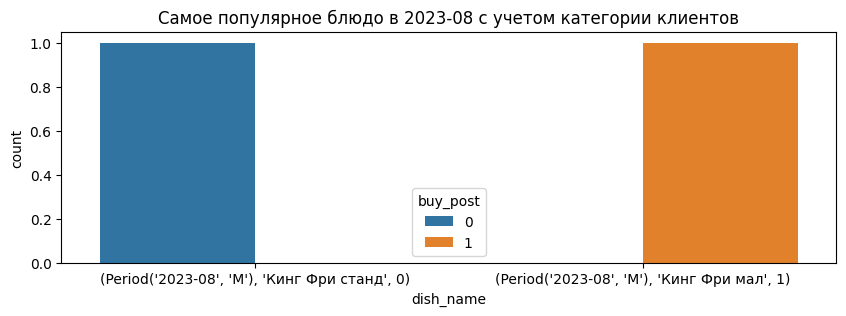

In [45]:
# Преобразование колонки startdatetime к типу данных datetime
train_df['startdatetime'] = pd.to_datetime(train_df['startdatetime'])

# Создание новой колонки month_year, которая содержит только месяц и год из startdatetime
train_df['month_year'] = train_df['startdatetime'].dt.to_period('M')

# Группировка данных по month_year, dish_name и buy_post, подсчет количества раз, когда каждое блюдо было заказано в каждом месяце и году
grouped = train_df.groupby(['month_year', 'dish_name', 'buy_post']).size()

# Нахождение самого популярного блюда для каждого месяца и года для каждой категории клиентов
most_popular_dishes = grouped.groupby(['month_year', 'buy_post']).idxmax()

# Создание DataFrame для хранения результатов
results = pd.DataFrame(most_popular_dishes, columns=['dish_name'])

# Разделение индекса на отдельные столбцы
results.reset_index(inplace=True)

# Создание отдельных графиков для каждого месяца и года
for month_year in results['month_year'].unique():
    subset = results[results['month_year'] == month_year]
    plt.figure(figsize=(10, 3))
    sns.countplot(x='dish_name', hue='buy_post', data=subset)
    plt.title(f'Самое популярное блюдо в {month_year} с учетом категории клиентов')
    plt.show()


## Откуда утекают клиенты

In [48]:
# Группировка данных по 'format_name' и 'buy_post', подсчет количества клиентов в каждой группе
grouped = train_df.groupby(['format_name', 'buy_post']).size()

# Выделение данных только для клиентов, которые ушли
churned = grouped[:, 0]

# Сортировка данных по убыванию для определения ресторанов с наибольшим количеством ушедших клиентов
churned_sorted = churned.sort_values(ascending=False)

print(churned_sorted)


format_name
Фудкорт без туалета                              973229
Отдельно стоящий с внешней зоной                 463865
Отдельно стоящий без внешней зоны                354990
Отдельно стоящий                                 327769
Фудкорт с туалетом                               243128
Отдельно стоящий без внешней зоны без туалета     57951
Отдельно стоящий без туалета                      31334
Отдельно стоящий с внешн.зоной без туалета        16251
dtype: int64


## Средний чек по ресторанам

In [66]:
# Группировка данных по 'customer_id', 'format_name', 'date' и 'buy_post', подсчет суммы 'revenue' в каждой группе
grouped = train_df.groupby(['customer_id', 'format_name', 'startdatetime', 'buy_post'])['revenue'].sum().reset_index()

# Группировка полученных данных по 'format_name' и 'buy_post', вычисление среднего значения 'revenue'
average_bill = grouped.groupby(['format_name', 'buy_post'])['revenue'].mean()

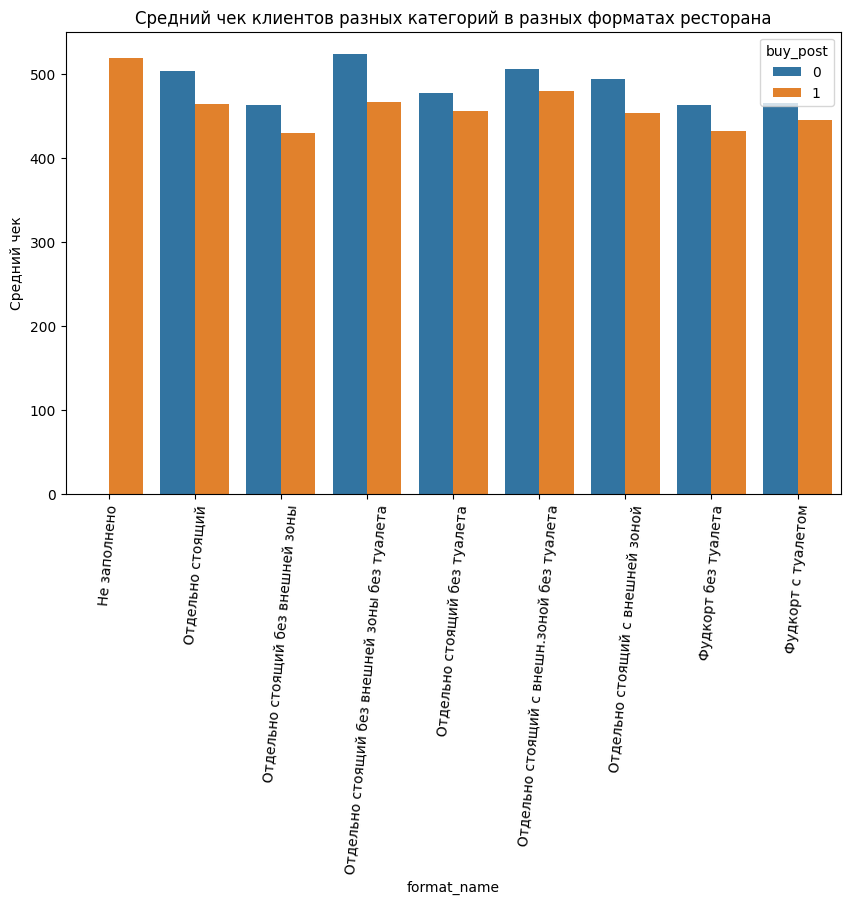

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Создание нового DataFrame для визуализации
average_bill_df = average_bill.reset_index()

# Создание графика
plt.figure(figsize=(10, 6))
sns.barplot(x='format_name', y='revenue', hue='buy_post', data=average_bill_df)
plt.title('Средний чек клиентов разных категорий в разных форматах ресторана')
plt.ylabel('Средний чек')
plt.xticks(rotation=85)  # Поворот названий ресторанов на 90 градусов
plt.show()

## Средний чек клиентов по месяцам

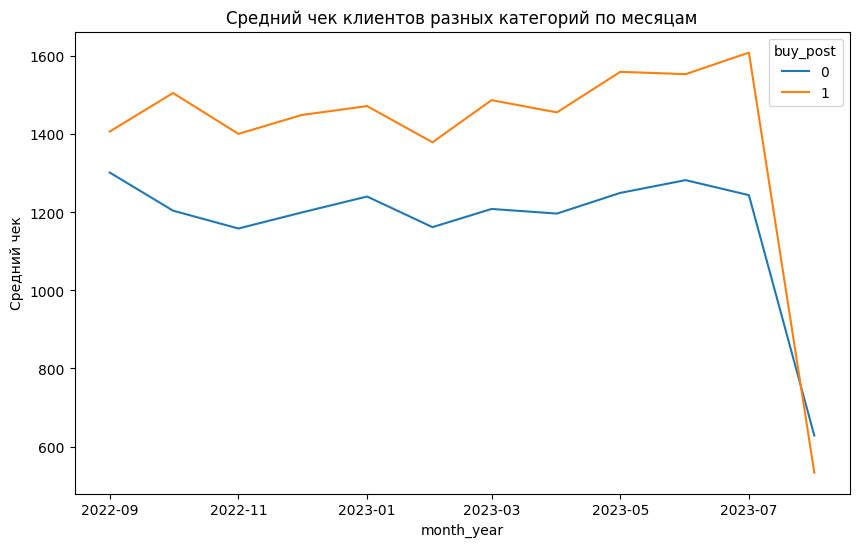

In [74]:
# Создание новой колонки month_year, которая содержит только месяц и год из startdatetime
train_df['month_year'] = train_df['startdatetime'].dt.to_period('M')

# Группировка данных по 'month_year', 'customer_id' и 'buy_post', подсчет суммы 'revenue' в каждой группе
grouped = train_df.groupby(['month_year', 'customer_id', 'buy_post'])['revenue'].sum().reset_index()

# Группировка полученных данных по 'month_year' и 'buy_post', вычисление среднего значения 'revenue'
average_bill = grouped.groupby(['month_year', 'buy_post'])['revenue'].mean().reset_index()

# Преобразование month_year обратно в формат даты
average_bill['month_year'] = average_bill['month_year'].dt.to_timestamp()

# Создание графика
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='revenue', hue='buy_post', data=average_bill)
plt.title('Средний чек клиентов разных категорий по месяцам')
plt.ylabel('Средний чек')
plt.show()

## Самые популярные позиции в 'среднем' чеке

In [104]:
import pandas as pd

# Предполагается, что ваш исходный датафрейм называется df
# Группировка данных по customer_id и startdatetime
grouped_data = train_df.groupby(['customer_id', 'startdatetime'])

# Создание списка товаров для каждого чека
receipts = grouped_data['dish_name'].apply(list).reset_index(name='dishes')

# Опционально: добавление других полезных столбцов, например, общей выручки каждого чека
receipts['total_revenue'] = grouped_data['revenue'].sum().values

In [107]:
import pandas as pd

# Предполагается, что ваш исходный датафрейм называется df
# Группировка данных по customer_id и startdatetime
grouped_data = train_df.groupby(['customer_id', 'startdatetime'])

# Создание списка товаров для каждого чека и подсчет количества позиций
receipts = grouped_data['dish_name'].apply(list).reset_index(name='dishes')
receipts['items_count'] = receipts['dishes'].apply(len)

# Подсчет общей выручки, средней, максимальной и минимальной стоимости позиции в чеке
receipts['total_revenue'] = grouped_data['revenue'].sum().values
receipts['average_item_price'] = grouped_data['revenue'].mean().values
receipts['max_item_price'] = grouped_data['revenue'].max().values
receipts['min_item_price'] = grouped_data['revenue'].min().values

# Подсчет общего количества чеков для каждого клиента
total_receipts_per_customer = train_df.groupby('customer_id').size().reset_index(name='total_receipts')

# Объединение этой информации с основным датафреймом чеков
receipts = receipts.merge(total_receipts_per_customer, on='customer_id')

In [109]:
receipts.head()

,customer_id,startdatetime,dishes,items_count,total_revenue,average_item_price,max_item_price,min_item_price,total_receipts
0,29891,2022-12-05 12:03:58,"[Кинг Фри станд, Чикен Тар-Тар, Соус Сырный, Э...",4,389.97,97.4925,190.00,9.99,34
1,29891,2022-12-05 14:28:35,[Латте (СТАНД.)],1,119.99,119.9900,119.99,119.99,34
2,29891,2022-12-15 00:37:19,"[Чизбургер, Воппер Ролл]",2,269.99,134.9950,209.99,60.00,34
3,29891,2022-12-20 09:20:38,[ЧизБекон Чикен Гамбургер],1,144.97,144.9700,144.97,144.97,34
4,29891,2022-12-21 09:46:23,[Цезарь Кинг новый],1,184.96,184.9600,184.96,184.96,34


Также, по но месяцам

In [111]:
import pandas as pd

# Предполагается, что ваш исходный датафрейм называется df
# Добавление информации о месяце
train_df['month'] = train_df['startdatetime'].dt.month

# Группировка данных по customer_id и месяцу
grouped_by_month = train_df.groupby(['customer_id', 'month'])

# Подсчет статистик по каждому клиенту в каждом месяце
monthly_stats = grouped_by_month.agg(total_receipts=('revenue', 'size'),
                                     average_receipt_value=('revenue', 'mean'),
                                     total_monthly_revenue=('revenue', 'sum'),
                                     max_receipt_value=('revenue', 'max'),
                                     min_receipt_value=('revenue', 'min')).reset_index()

In [112]:
monthly_stats

,customer_id,month,total_receipts,average_receipt_value,total_monthly_revenue,max_receipt_value,min_receipt_value
0,29891,1,9,109.098889,981.89,329.96,1.00
1,29891,2,1,439.980000,439.98,439.98,439.98
2,29891,12,24,152.728333,3665.48,319.95,1.00
3,30477,10,25,105.594000,2639.85,399.99,1.00
4,30477,11,36,84.326389,3035.75,299.98,0.39
...,...,...,...,...,...,...,...
918808,46624509,8,5,64.192000,320.96,99.99,1.00
918809,46625265,7,13,92.297692,1199.87,169.98,49.99
918810,46639170,7,11,99.083636,1089.92,179.99,1.00
918811,46654016,8,6,203.321667,1219.93,429.99,129.98
